# Exploring the Intrinsic Interpretability in TabNet


We aim to explore and validate the intrinsic interpretability of the TabNet model using multiple established explainability techniques

# Outline

1. [Introduction and Setup](#Introduction-and-Setup)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Model Training](#Model-Training)
4. [Approach 1: Permutation Feature Importance](#Approach-1:-Permutation-Feature-Importance)
5. [Approach 2: Feature Relationships using Partial Dependence Plots](#Approach-2:-Feature-Relationships-using-Partial-Dependence-Plots)
6. [Approach 3: Analysis of TabNet's Attention Mechanism](#Approach-3:-Analysis-of-TabNet's-Attention-Mechanism)
7. [Approach 4: Comparing Instance-level Explanations using Lime and TabNet's Attention](#Approach-4:-Comparing-Instance-level-Explanations-using-Lime-and-TabNet's-Attention)

# Introduction and Setup

TabNet is a deep learning architecture specifically designed for tabular data, introduced by Google Research in 2019. It combines the powerful feature learning capabilities of neural networks with built-in interpretability mechanisms, making it particularly valuable for domains requiring both high performance and model transparency.

Key components of TabNet:
- **Sequential Attention**: Uses multiple decision steps where each step processes the most relevant features
- **Feature Selection**: Employs sparse feature selection using masked attention
- **Instance-wise Feature Selection**: Adapts feature selection for each input independently

TabNet's interpretability features:
- Built-in feature importance scores
- Per-instance feature attribution
- Step-wise decision masks
- Sparsity in feature selection

This notebook explores TabNet's interpretability claims by:
1. Validating feature importance against established methods
2. Analyzing feature relationships
3. Examining the attention mechanism
4. Comparing with other explanation frameworks (LIME)

In [1]:
import os
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from src.data.loader import DataLoader
from src.data.preprocessing import Preprocessor
from src.models.tabnet_model import RainPredictor
from pytorch_tabnet.augmentations import ClassificationSMOTE
import torch
import json
import logging
import lime
import lime.lime_tabular
import pickle  # For saving the preprocessor
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
import random
random.seed(seed)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Data Preprocessing

The `Preprocessor` class in `src/data/preprocessing.py` is responsible for preparing the raw data for modeling with TabNet. Here's an overview of its functionality:

## Key Responsibilities

1. **Initialization**:
   - **Label Encoders**: Initializes label encoders for categorical features to convert categorical data into numerical format.
   - **Feature Lists**: Specifies which features are categorical (`categorical_features`) and which are numerical (`numerical_features`).

2. **Preprocessing Method (`preprocess`)**:
   - **Data Cleaning**:
     - **Dropping Unnecessary Columns**: Removes the `Date` column and other columns with excessive missing values (`Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm`).
     - **Handling Missing Values**: Drops any remaining rows with missing values to ensure data integrity.
   
   - **Target Variable Processing**:
     - **Encoding**: Converts the target variable `RainTomorrow` from categorical (`'No'`, `'Yes'`) to numerical (`0`, `1`).
   
   - **Categorical Feature Encoding**:
     - **Training Phase**:
       - **Label Encoding**: Fits and transforms categorical features using `LabelEncoder`.
     - **Inference Phase**:
       - **Transformation**: Applies the fitted label encoders to transform categorical features.
   
   - **Output Preparation**:
     - Returns the processed DataFrame, its NumPy array representation, and the encoded target variable.

3. **Saving and Loading Preprocessor State**:
   - **Save Method (`save`)**: Serializes and saves the state of label encoders, scaler, feature means, and categorical modes using `pickle`.
   - **Load Method (`load`)**: Deserializes and loads the saved preprocessor state, allowing for consistent preprocessing during inference.

## Usage in the Workflow

During the **training phase**, the `Preprocessor`:
- Fits the label encoders on the training data.
- Transforms the training, validation, and test datasets accordingly.

During the **inference phase**, the `Preprocessor`:
- Loads the saved state to ensure that new data is transformed consistently with the training data.

# Model Training

In [2]:
# Set to True to train model from scratch, False to load model from disk
# our model is trained on a gpu, so results may vary if training on a cpu
TRAIN_FROM_SCRATCH = False


categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
                      'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Load configuration with absolute paths
with open('config.json', 'r') as f:
    config = json.load(f)

# Initialize components with config parameters
data_loader = DataLoader(config['data_path'])
preprocessor = Preprocessor()

# Load and split data
logger.info("Loading data...")
data = data_loader.load_data()
train_df, val_df, test_df = data_loader.split_data(data)

# Preprocess data
logger.info("Preprocessing data...")
df_train, X_train, y_train = preprocessor.preprocess(train_df, is_training=True)  # Use instance method
df_val, X_val, y_val = preprocessor.preprocess(val_df, is_training=False)  # Use instance method
df_test, X_test, y_test = preprocessor.preprocess(test_df, is_training=False)  # Use instance method

cat_idxs = [f for f, feature in enumerate(df_train.columns) if feature in categorical_features]
cat_dims = [len(preprocessor.label_encoders[feature].classes_) for f, feature in enumerate(df_train.columns) if feature in categorical_features]

config['model_params']["cat_idxs"] = cat_idxs
config['model_params']["cat_dims"] = cat_dims

# Train model with config parameters
model = RainPredictor(config['model_params'])

if TRAIN_FROM_SCRATCH:
    aug = ClassificationSMOTE(p=0.2)
    logger.info("Training model...")
    model.fit(
        X_train, y_train,
        X_val, y_val,
        num_epochs=10,
        batch_size=config['batch_size'],
        virtual_batch_size=config['virtual_batch_size'],
        augmentations=aug,
    )
    logger.info("Saving model to disk...")
    model.save_model(config['model_path'])
    # save model history to file to pickle
    with open(config['model_path'] + '_history.json', 'w') as f:
        history = model.model.history.history
        json.dump(history, f)
        
else:
    logger.info("Loading model from disk...")
    model.load_model(config['model_path'] + '.zip')
    with open(config['model_path'] + '_history.json', 'r') as f:
        history = json.load(f)

INFO:__main__:Loading data...
INFO:__main__:Preprocessing data...
/home/paul/miniconda3/envs/tabnet2/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
INFO:__main__:Loading model from disk...
/home/paul/miniconda3/envs/tabnet2/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

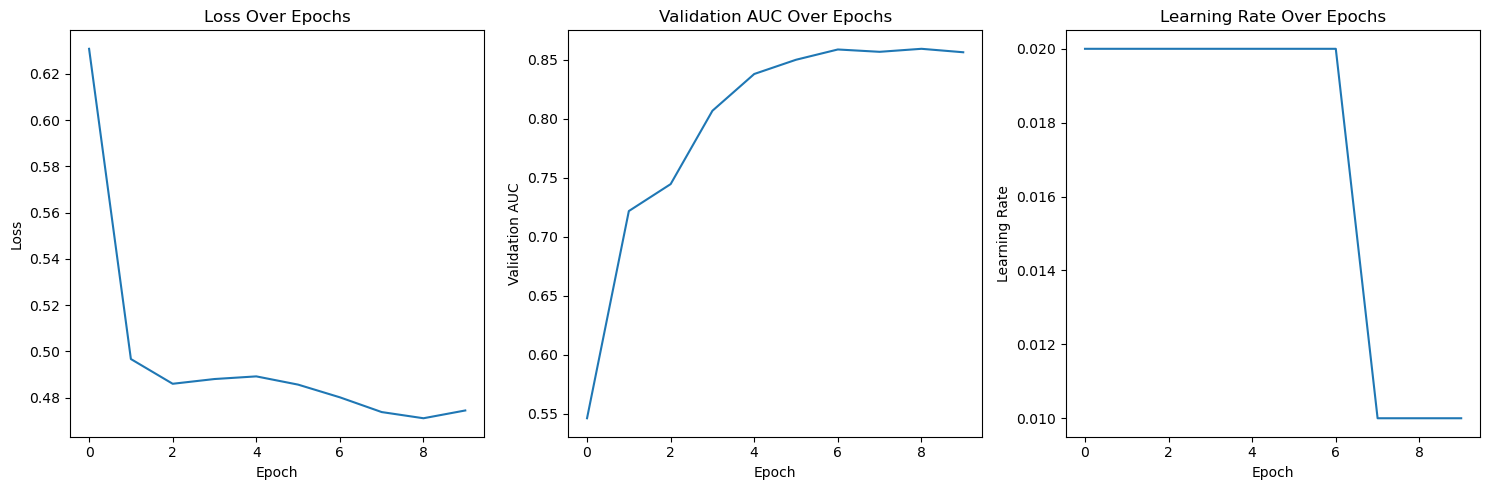

In [3]:
def plot_training_history(history):
    """Plot available training metrics from TabNet model."""
    # Get available metrics
    available_metrics = list(history.keys())
    
    # Determine which plots to create based on available metrics
    plots = []
    if 'loss' in available_metrics:
        plots.append(('loss', 'Loss'))
    if 'accuracy' in available_metrics:
        plots.append(('accuracy', 'Accuracy'))
    if 'valid_auc' in available_metrics:
        plots.append(('valid_auc', 'Validation AUC'))
    if 'lr' in available_metrics:
        plots.append(('lr', 'Learning Rate'))
    
    # Create subplots based on available metrics
    fig, axes = plt.subplots(1, len(plots), figsize=(5*len(plots), 5))
    if len(plots) == 1:
        axes = [axes]
    
    # Plot each metric
    for idx, (metric, title) in enumerate(plots):
        axes[idx].plot(history[metric])
        if f'val_{metric}' in available_metrics:
            axes[idx].plot(history[f'val_{metric}'], label=f'Validation {title}')
        axes[idx].set_title(f'{title} Over Epochs')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(title)
        # axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Approach 1: Permutation Feature Importance

The TabNet-model has its own method of calculating feature importance by aggregating the attention masks and calculating the ratio of attention assigned to each feature to the total attention. The Permutation Feature Importance method allows us to verify and confirm those importances.

## TabNet's builtin Feature Importance

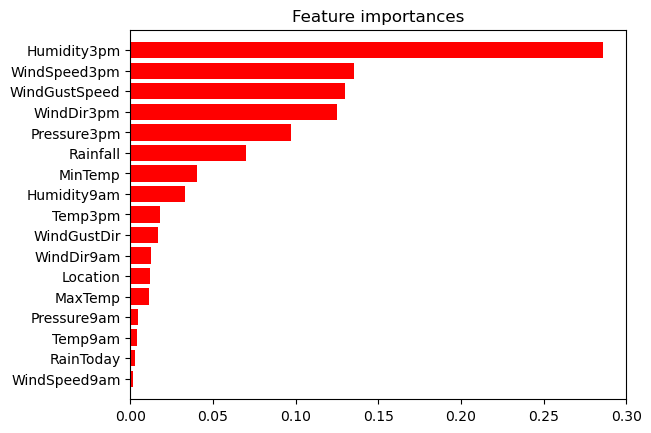

In [4]:
feat_importances = model.model._compute_feature_importances(X_test)

sorting = np.argsort(feat_importances)
sorted_feat_importances = feat_importances[sorting]
labels = df_test.columns[sorting]

plt.figure()
plt.title("Feature importances")
plt.barh(range(len(sorted_feat_importances)), sorted_feat_importances,
       color="r", align="center")
plt.yticks(range(len(sorted_feat_importances)), labels)
plt.ylim([-1, len(sorted_feat_importances)])
plt.show()

## Permutation Feature Importance 

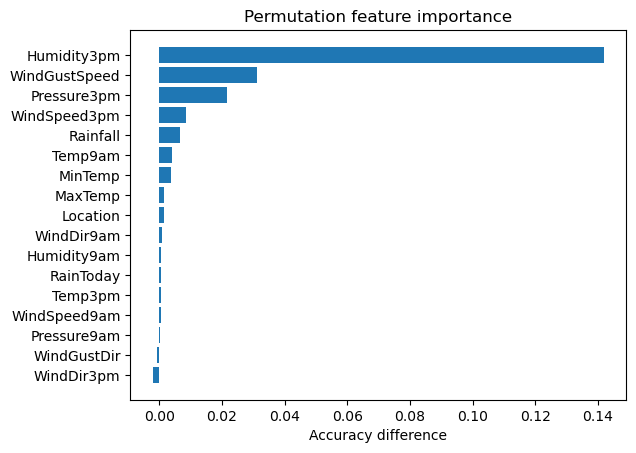

In [5]:
def get_perm_feat_imp(model, X, y_true):
    y_pred = model.predict(X)

    a_orig = accuracy_score(y_true, y_pred)

    importances = []
    for f in range(len(X[0])):
        # Shuffle feature column
        X_perm = X.copy()
        f_perm = X_perm[:, f]
        np.random.shuffle(f_perm)
        X_perm[:, f] = f_perm

        # Get score for permutated data
        y_pred_perm = model.predict(X_perm)
        a_perm = accuracy_score(y_true, y_pred_perm)

        # Calculate importance
        importances.append(a_orig - a_perm)

    return np.array(importances)

perm_feat_imps = get_perm_feat_imp(model.model, X_test, y_test)

sorting = np.argsort(perm_feat_imps)
bar_values = perm_feat_imps[sorting]
y_labels = df_test.columns[sorting]

y_pos = np.arange(len(y_labels))
plt.barh(y_pos, bar_values)
plt.yticks(y_pos, labels=y_labels)
plt.xlabel('Accuracy difference')
plt.title('Permutation feature importance')

plt.show()

## Comparison of Feature Importance Scores

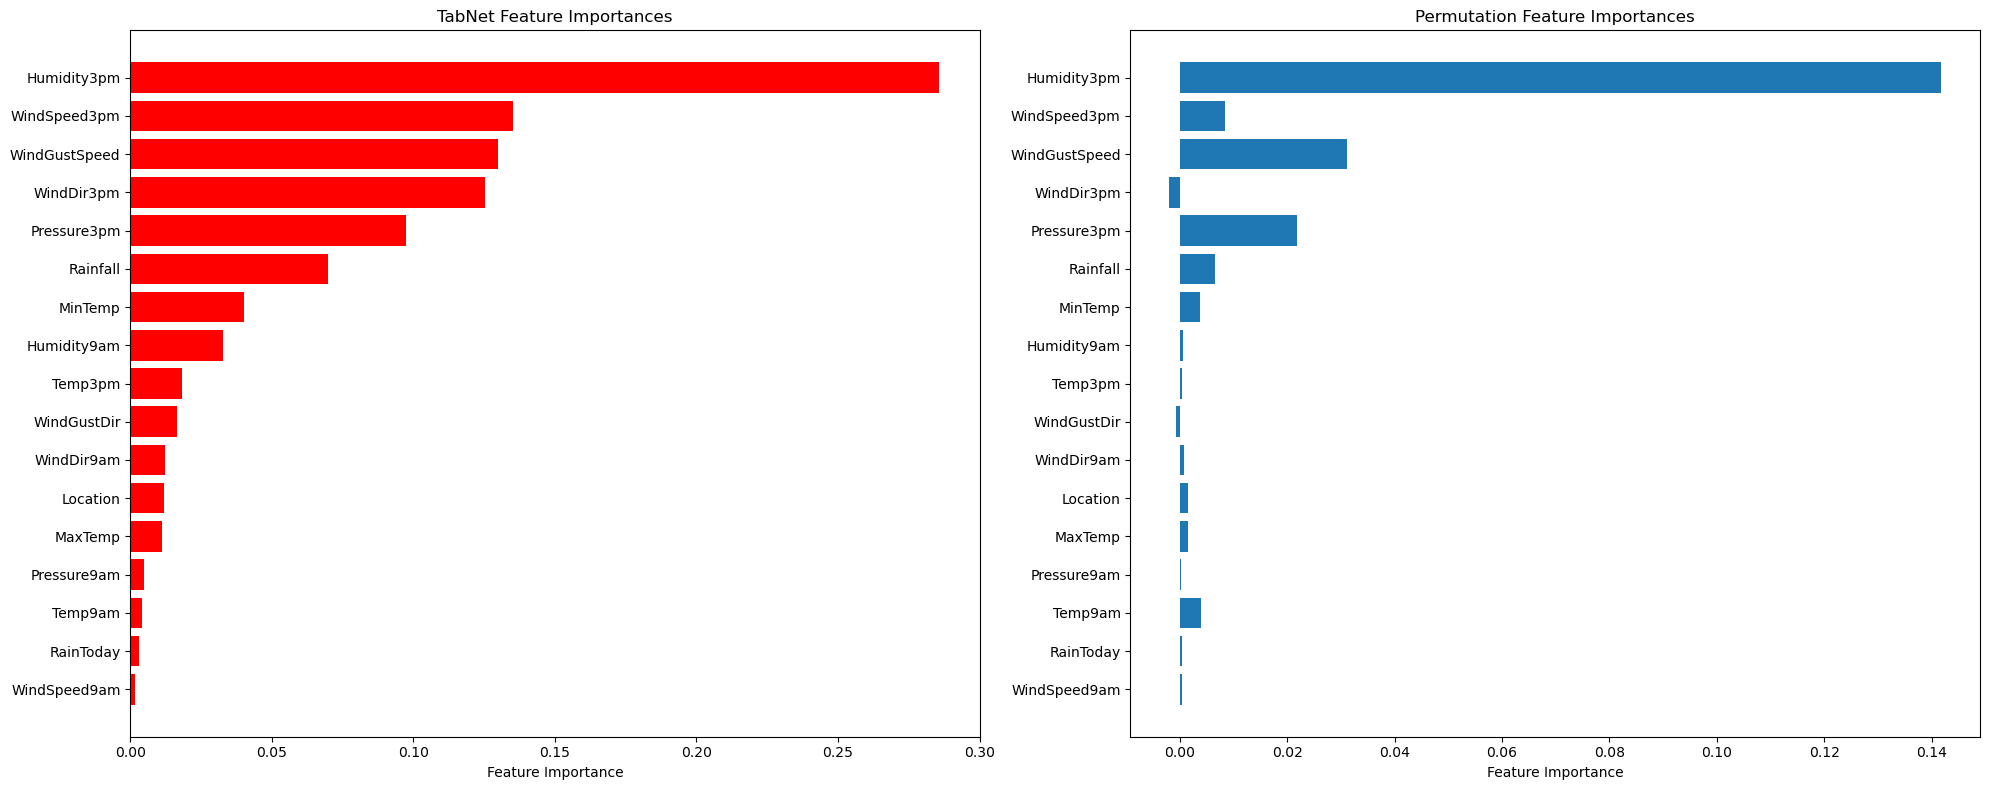

In [6]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

# Sort both plots based on TabNet feature importances
sorting = np.argsort(feat_importances)
tab_imp = feat_importances[sorting]
perm_imp = perm_feat_imps[sorting]  # Use same sorting
labels = df_test.columns[sorting]

# Plot TabNet feature importances
ax1.barh(np.arange(len(tab_imp)), tab_imp, align='center', color='r')
ax1.set_yticks(np.arange(len(tab_imp)))
ax1.set_yticklabels(labels)
ax1.set_xlabel('Feature Importance')
ax1.set_title('TabNet Feature Importances')

# Plot Permutation feature importances with same order
ax2.barh(np.arange(len(perm_imp)), perm_imp, align='center')
ax2.set_yticks(np.arange(len(perm_imp)))
ax2.set_yticklabels(labels)
ax2.set_xlabel('Feature Importance')
ax2.set_title('Permutation Feature Importances')
plt.tight_layout()
plt.show()

We can see that the importances computed by both methods seem to agree in their ranking of features, so the model has good intrinsic interpretability. 

As for the results themselves, the first takeaway is that the humidity at 03:00PM in the afternoon is by far the most important feature for the model. This aligns with scientific reality, as the probability of rain is directly dependent on the humidity of the air. It is a similar case for wind and air pressure, as differences in air pressure cause strong wind, which encourages cloud formation. Another relation can be observed where the model mostly prefers measurements in the afternoon over those in the morning for next day prediction.

# Approach 2: Feature Relationships using Partial Dependence Plots

In [7]:
def get_partial_dependence(model, data, feature_id, feature_values):
    results = []
    
    for val in feature_values:
        modified_data = data.copy()
        modified_data[:, feature_id] = val
        
        predictions = model.predict_proba(modified_data)

        results.append(np.mean(predictions[:, 1]))

    return results

def get_partial_dependences(model, preprocessor, dataframe):
    # Get numpy data
    transformed_data = dataframe.to_numpy()#preprocessor.scaler.transform(dataframe)

    # data points for predicting and plotting
    all_unique_feature_values = []
    # Mean prediction per feature and feature value
    probability_values = []

    # Compute partial dependence for every feature
    for f, feature in enumerate(dataframe.columns):
        print(f"Computing partial dependence for {feature}")

        # Get unique values for model prediction, normalized
        unique_feature_values = np.unique(transformed_data[:, f])
        # If too many for numeric feature, interpolate between min and max
        if feature in numerical_features and len(unique_feature_values) > 50:
            unique_feature_values = np.linspace(min(transformed_data[:, f]), max(transformed_data[:, f]), 50)

        # If categorical feature: get decoded value
        if feature in categorical_features:
            all_unique_feature_values.append(preprocessor.label_encoders[feature].inverse_transform(unique_feature_values.astype(int)))
        else:
            all_unique_feature_values.append(unique_feature_values)

        probability_values.append(get_partial_dependence(model, transformed_data, f, unique_feature_values))

    return all_unique_feature_values, probability_values

pdp_x, pdp_y = get_partial_dependences(model.model, preprocessor, df_test)

Computing partial dependence for Location
Computing partial dependence for MinTemp
Computing partial dependence for MaxTemp
Computing partial dependence for Rainfall
Computing partial dependence for WindGustDir
Computing partial dependence for WindGustSpeed
Computing partial dependence for WindDir9am
Computing partial dependence for WindDir3pm
Computing partial dependence for WindSpeed9am
Computing partial dependence for WindSpeed3pm
Computing partial dependence for Humidity9am
Computing partial dependence for Humidity3pm
Computing partial dependence for Pressure9am
Computing partial dependence for Pressure3pm
Computing partial dependence for Temp9am
Computing partial dependence for Temp3pm
Computing partial dependence for RainToday


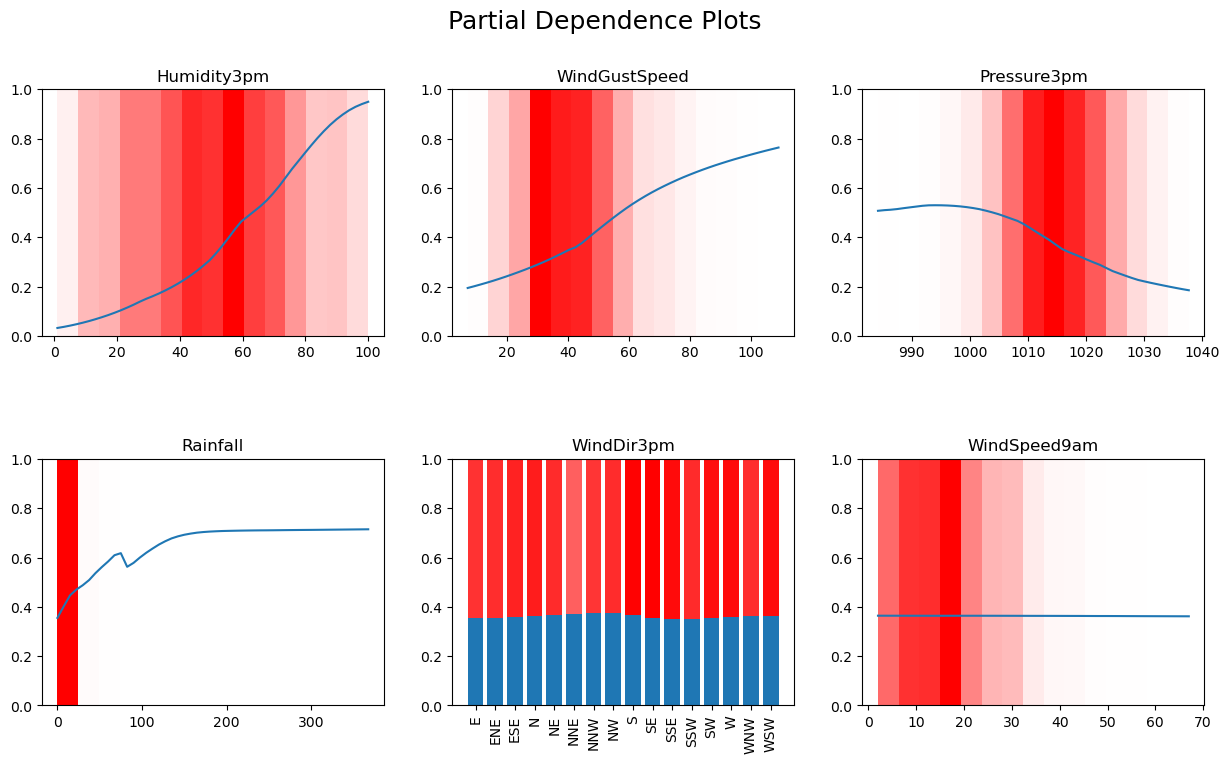

In [8]:
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Partial Dependence Plots", fontsize=18)

plot_features = ["Humidity3pm", "WindGustSpeed", "Pressure3pm", "Rainfall", "WindDir3pm", "WindSpeed9am"]

# loop through tickers and axes
for feature, ax in zip(plot_features, axs.ravel()):
    f = np.where(df_test.columns==feature)[0][0]
    if feature in categorical_features:
        densities, bin_edges = np.histogram(df_test[feature], bins=len(np.unique(df_test[feature])), density=True)
        densities = densities / np.max(densities)
        colors = [(1, 0, 0, density) for density in densities]
        
        ax.bar(pdp_x[f], height=1, color=colors)
        ax.bar(pdp_x[f], pdp_y[f])
        ax.set_xticks(pdp_x[f], labels=pdp_x[f], rotation=90)
    else:
        densities, bin_edges = np.histogram(df_test[feature], bins=15, density=True)
        bar_width = bin_edges[1] - bin_edges[0]
        bar_locations = bin_edges[:-1] + bar_width/2
        densities = densities / np.max(densities)
        colors = [(1, 0, 0, density) for density in densities]
        
        ax.plot(pdp_x[f], pdp_y[f])
        ax.bar(bar_locations, height=1, width=bar_width, color=colors)

    ax.set_ylim(0, 1)
    # chart formatting
    ax.set_title(feature)

plt.show()


This gives us more insight in how the prediction is affected by the feature values. The most notable feature is again Humidity3PM, which has a near linear relation to the target. This again lines up with scientific consensus, where at 0% humidity rain is not possible and at 100% rain has to fall. Generally, it can be observed that the features with low importance have little variance on the y-axis.

Overlaying the plots with a histogram shows that most of the features have pretty evenly distributed values. One notable outlier is Rainfall, which measures the rainfall at a given day in millimeters. Apparently, there was one day in the last ten years, where Australia received catastrophic rainfall at 367 mm.

# Approach 3: Analysis of TabNet's Attention Mechanism

## Per Instance Masks

In the visualization:

    Yellow regions indicate high attention (important features).
    Darker regions signify low or no attention.
    The rows correspond to different instances in the dataset.
    While the columns represent the features.

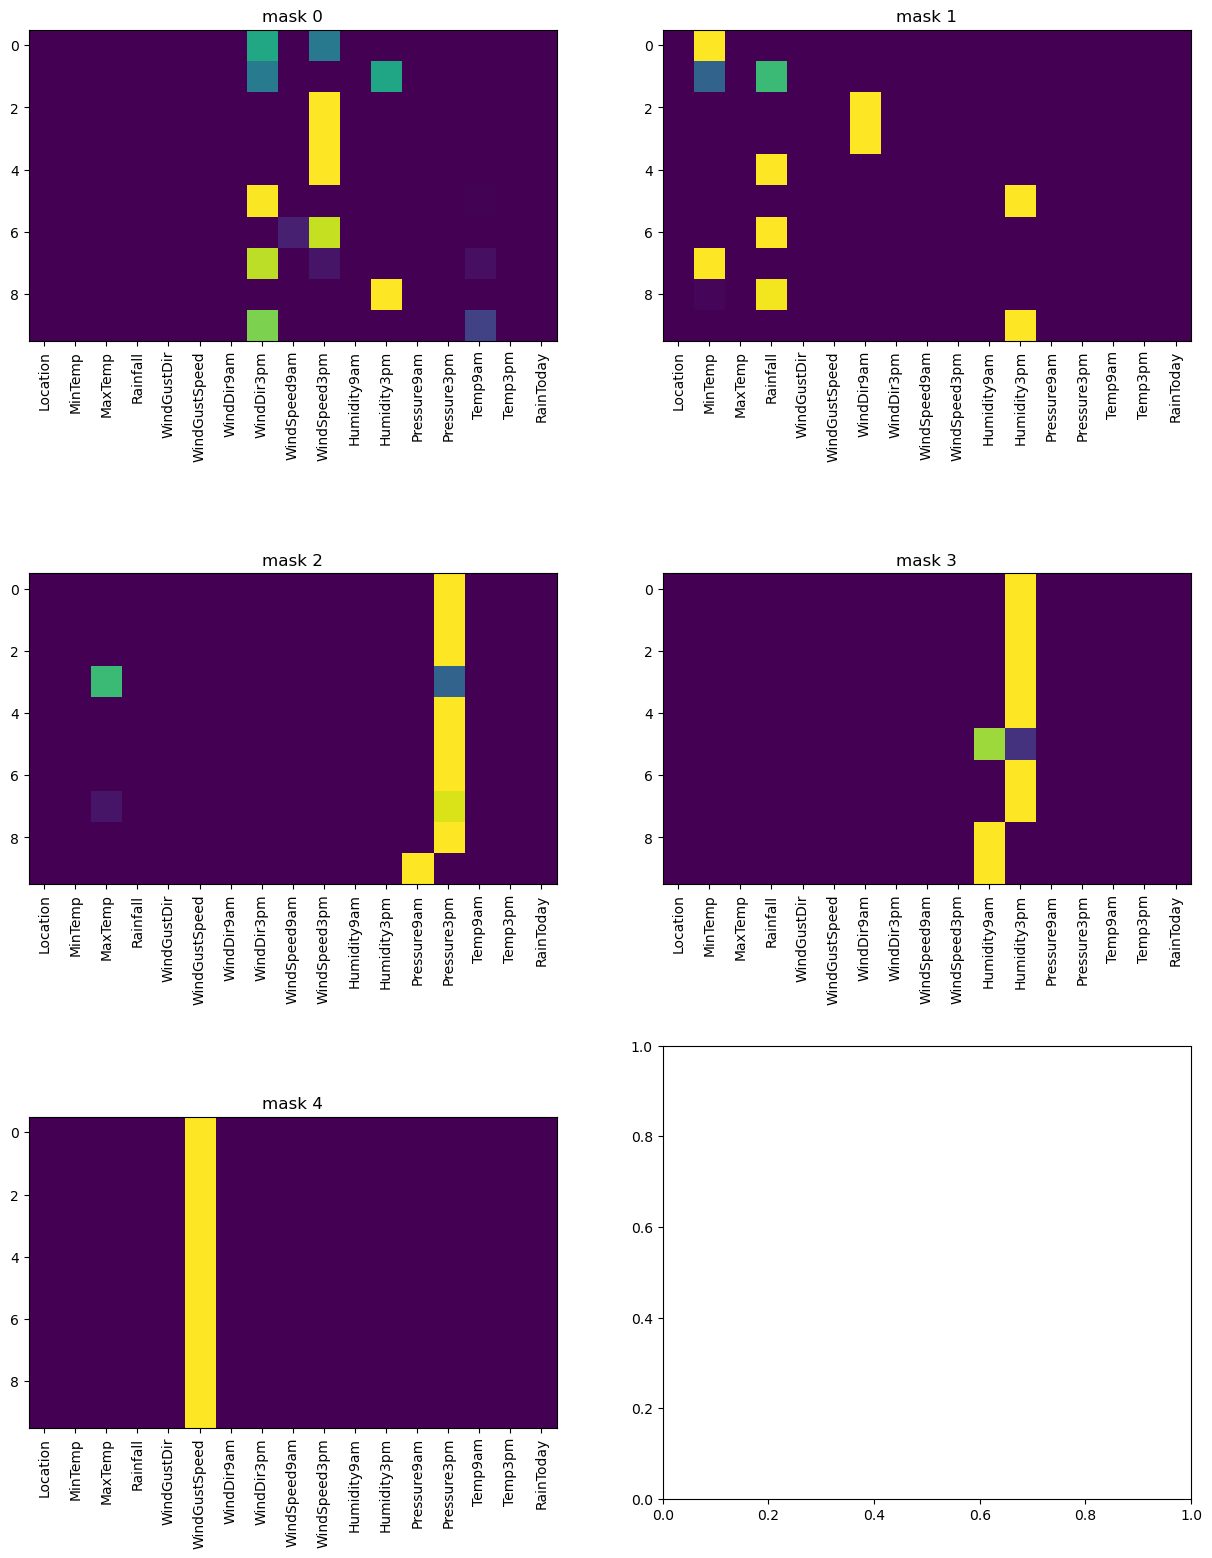

In [9]:
explain_matrix, masks = model.model.explain(X_test)

fig, axs = plt.subplots(3, 2, figsize=(15,20))

for i in range(len(masks)):
    axs[i//2, i%2].imshow(masks[i][:10])
    axs[i//2, i%2].set_title(f"mask {i}")
    axs[i//2, i%2].set_xticks(np.arange(len(df_test.columns)), labels=df_test.columns, rotation=90)

## Aggregated Masks

In the aggregated masks visualization, we combine the per-instance masks to identify common patterns in feature selection across the dataset. 

In the visualization:

    The x-axis represents the features.
    The y-axis corresponds to the decision steps.
    The color intensity indicates the average attention weight for each feature across all instances.
    Features with higher average attention are more important for the model's decisions.

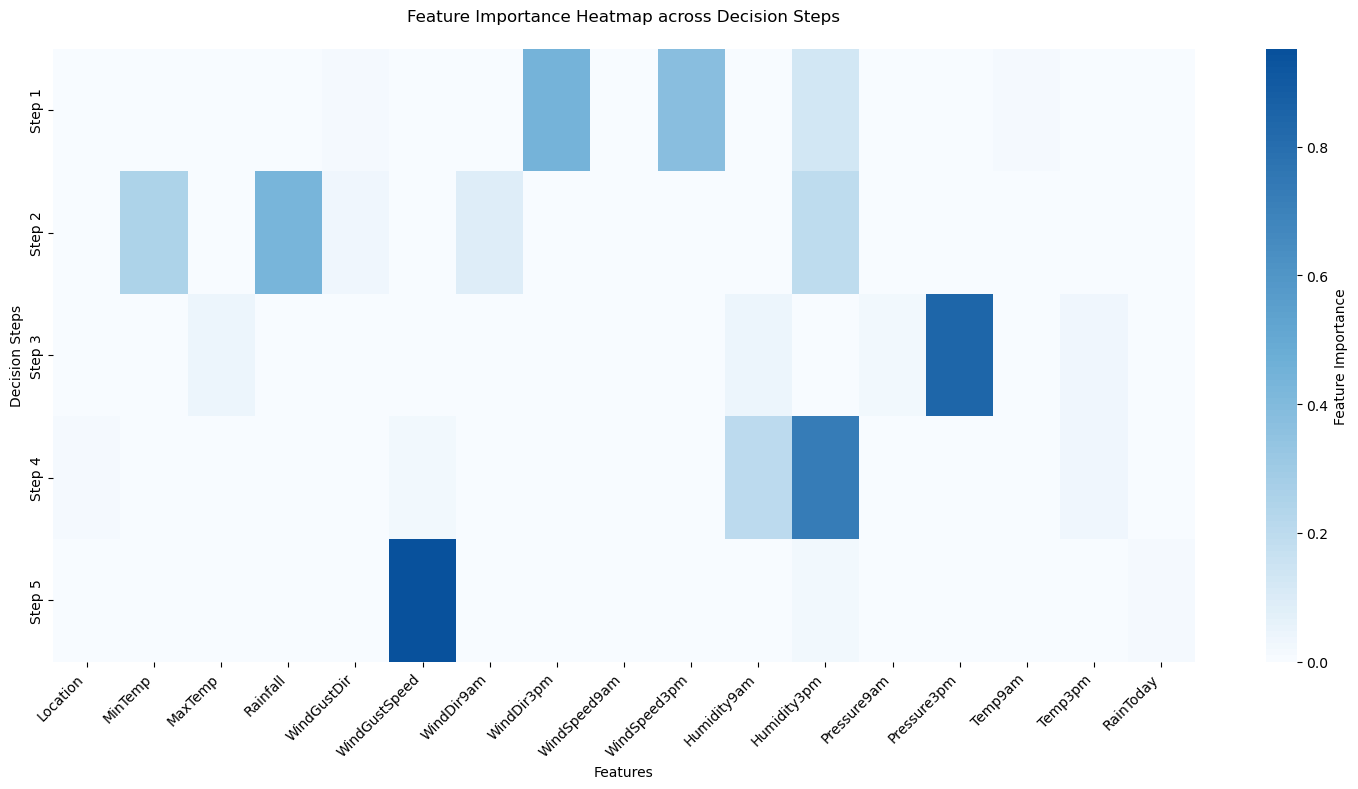

In [10]:
# Create custom colormap
colors = ["#f7fbff", "#6baed6", "#08519c"]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

def plot_feature_importance_heatmap(masks_list, feature_names):
    """Plot heatmap of feature importance across decision steps"""
    # Calculate mean masks across samples
    mean_masks = [mask.mean(axis=0) for mask in masks_list]
    mask_matrix = np.vstack(mean_masks)

    plt.figure(figsize=(15, 8))
    sns.heatmap(
        mask_matrix,
        cmap=custom_cmap,
        xticklabels=feature_names,
        yticklabels=[f"Step {i+1}" for i in range(len(masks_list))],
        cbar_kws={"label": "Feature Importance"},
    )
    plt.title("Feature Importance Heatmap across Decision Steps", pad=20)
    plt.xlabel("Features")
    plt.ylabel("Decision Steps")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


feature_names = list(df_test.columns)
masks_list = [masks[i] for i in range(len(masks))]
plot_feature_importance_heatmap(masks_list, feature_names)

These visualizations help to explain the decision making process of the model. Each decision step seems to favor completely separate features from the others. Notably, the attributions seem to get more concentrated with the later steps, where the last one almost exclusively uses one feature only. 
This might indicate that the model first tries to find the most important features for the individual instances and then refines the prediction by focusing on the same features for all instances.

Another interesting observation is regarding our most important feature Humidity3pm. While it is not the most attributed feature overall in the aggregated graph, it is the only that received strong attention across multiple decision steps (1, 2, 4).

# Approach 4: Comparing Instance-level Explanations using Lime and TabNet's Attention

In this final approach we want to evaluate TabNet's interpretability on the instance level. For this we will look at the feature attributions of a single sample over all decision steps combined and compare that to the explanations generated by the LIME-method.

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df_train.columns, mode="classification", class_names=['No Rain', 'Rain'], discretize_continuous=True)

# Select a sample to explain
sample_i = 4242
true_label = "Rain" if y_test[sample_i] == 1 else "No Rain"
print(f"True label: {true_label}")
exp = explainer.explain_instance(X_test[sample_i], model.model.predict_proba, num_features=17)
exp.show_in_notebook(show_table=True)

True label: No Rain


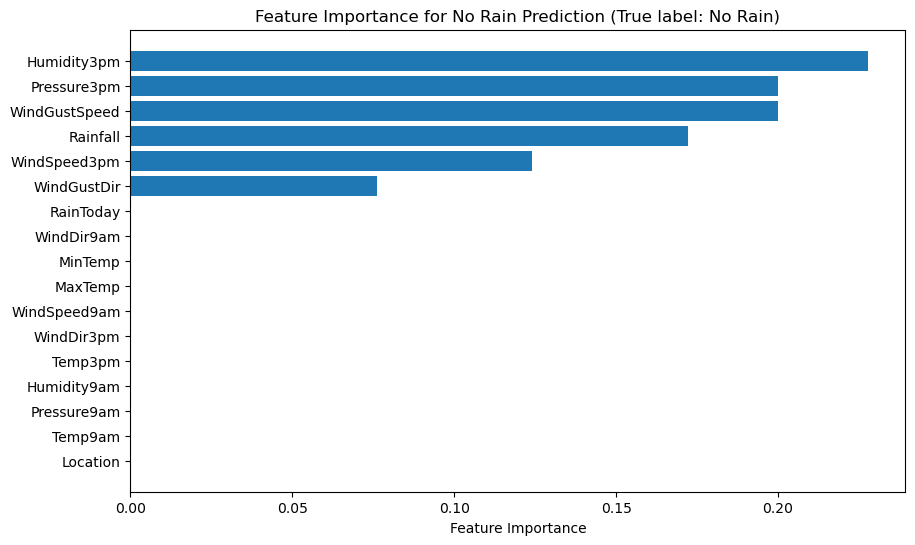

In [12]:

def plot_sample_feature_importance(model, masks, sample_i, df_train):
    """Plot feature importance for a single sample"""
    # get masks for this sample
    sample_masks = [masks[i][sample_i] for i in range(len(masks))]
    sample_masks = np.vstack(sample_masks)

    # get model prediction for this sample
    sample_pred = model.model.predict(X_test[sample_i].reshape(1, -1))
    # sample_pred_proba = model.model.predict_proba(X_test[sample_i].reshape(1, -1))

    # average over steps to get feature importance for this sample
    sample_feature_importance = sample_masks.mean(axis=0)
    # sort features by importance
    sorting = np.argsort(sample_feature_importance)
    sample_feature_importance = sample_feature_importance[sorting]
    feature_names = np.array(list(df_train.columns))[sorting]

    sample_pred_label = "Rain" if sample_pred[0] == 1 else "No Rain"

    # plot feature importance for this sample
    plt.figure(figsize=(10, 6))
    plt.barh(np.arange(len(sample_feature_importance)), sample_feature_importance)
    plt.yticks(np.arange(len(sample_feature_importance)), labels=feature_names)
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {sample_pred_label} Prediction (True label: {true_label})')
    plt.show()

plot_sample_feature_importance(model, masks, sample_i, df_train)


In [13]:
# get misclassified samples
misclassified_samples = np.where(y_test != model.model.predict(X_test))[0]

# select a misclassified sample to explain
sample_i_miss = misclassified_samples[3]
print("True label:", "Rain" if y_test[sample_i_miss] == 1 else "No Rain")
exp = explainer.explain_instance(X_test[sample_i_miss], model.model.predict_proba, num_features=17)
exp.show_in_notebook(show_table=True)

True label: No Rain


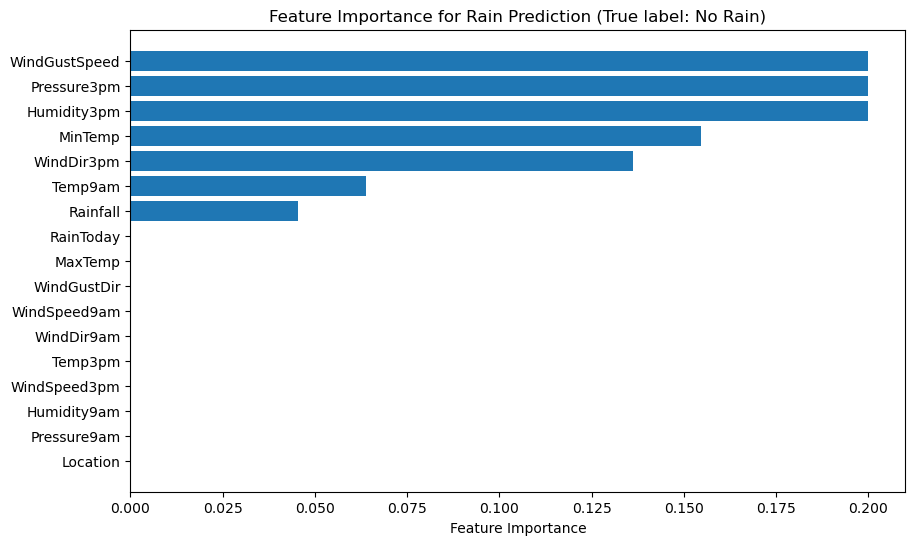

In [14]:
plot_sample_feature_importance(model, masks, sample_i_miss, df_train)

While the methods again agree on which features are influential, LIME shows a clear advantage over the intrinsic explanations as it also provides the concrete effect each feature value had on the prediction. This is especially helpful when analyzing false predictions.